In [39]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np

**Data Taken From:** https://www.kaggle.com/wordsforthewise/lending-club </br>
**Model is From:** https://www.kaggle.com/benesalvatore/predict-default-using-logisitic-regression

In [40]:
features = ['loan_amnt', 'annual_inc', 'term', 'emp_length']

In [41]:
a = pd.read_csv('accepted_2007_to_2018Q4.csv', usecols=features+['loan_status'])

In [42]:
a


,loan_amnt,term,emp_length,annual_inc,loan_status
0,3600.0,36 months,10+ years,55000.0,Fully Paid
1,24700.0,36 months,10+ years,65000.0,Fully Paid
2,20000.0,60 months,10+ years,63000.0,Fully Paid
3,35000.0,60 months,10+ years,110000.0,Current
4,10400.0,60 months,3 years,104433.0,Fully Paid
...,...,...,...,...,...
2260696,40000.0,60 months,9 years,227000.0,Current
2260697,24000.0,60 months,6 years,110000.0,Charged Off
2260698,14000.0,60 months,10+ years,95000.0,Current
2260699,NaN,NaN,NaN,NaN,NaN


In [43]:
# Just Fully Pid and Charge ogg in loan status
full_set = a.query("loan_status in ('Fully Paid', 'Charged Off')").copy()

In [44]:
full_set.sample(5)

,loan_amnt,term,emp_length,annual_inc,loan_status
1646580,16000.0,36 months,8 years,38000.0,Fully Paid
199031,9000.0,36 months,NaN,31000.0,Fully Paid
607131,35000.0,36 months,10+ years,135000.0,Fully Paid
537454,5000.0,36 months,2 years,36000.0,Charged Off
478483,4000.0,36 months,10+ years,41000.0,Fully Paid


In [45]:
#Quitar los Nans
full_set = full_set.dropna(subset=['emp_length'])

In [46]:
full_set.sample(5)


,loan_amnt,term,emp_length,annual_inc,loan_status
404220,20000.0,60 months,10+ years,90000.0,Fully Paid
296390,27200.0,36 months,10+ years,102000.0,Fully Paid
1802345,19000.0,36 months,10+ years,95000.0,Charged Off
1625337,4000.0,36 months,4 years,70000.0,Fully Paid
1334837,4000.0,36 months,2 years,48000.0,Fully Paid


# Build the model - Logistic Regression

1. Transform our Label *loan_status* and other columns

In [47]:
# Change for 1 & 0 withinn loan_status; & 36 o 60  in term
full_set['loan_status'] = full_set['loan_status'].replace(
    {
        'Fully Paid': 1,
        'Charged Off': 0
    }
)

full_set['term'] = full_set['term'].replace(
    {
        ' 36 months': 36,
        ' 60 months': 60
    }
)

In [48]:
full_set

,loan_amnt,term,emp_length,annual_inc,loan_status
0,3600.0,36,10+ years,55000.0,1
1,24700.0,36,10+ years,65000.0,1
2,20000.0,60,10+ years,63000.0,1
4,10400.0,60,3 years,104433.0,1
5,11950.0,36,4 years,34000.0,1
...,...,...,...,...,...
2260688,18000.0,60,5 years,130000.0,1
2260690,29400.0,60,9 years,180792.0,1
2260691,32000.0,60,3 years,157000.0,0
2260692,16000.0,60,10+ years,150000.0,1


In [49]:
#Split emp_lenght column and have the 1rst term
full_set['emp_length'] = full_set['emp_length'].map(lambda x: x.split(' ')[0])
full_set

,loan_amnt,term,emp_length,annual_inc,loan_status
0,3600.0,36,10+,55000.0,1
1,24700.0,36,10+,65000.0,1
2,20000.0,60,10+,63000.0,1
4,10400.0,60,3,104433.0,1
5,11950.0,36,4,34000.0,1
...,...,...,...,...,...
2260688,18000.0,60,5,130000.0,1
2260690,29400.0,60,9,180792.0,1
2260691,32000.0,60,3,157000.0,0
2260692,16000.0,60,10+,150000.0,1


In [50]:
#Clean emp_lenght column
full_set['emp_length'] = full_set['emp_length'].map(lambda x: str(x).replace('+', '').replace('<', '0'))
full_set

,loan_amnt,term,emp_length,annual_inc,loan_status
0,3600.0,36,10,55000.0,1
1,24700.0,36,10,65000.0,1
2,20000.0,60,10,63000.0,1
4,10400.0,60,3,104433.0,1
5,11950.0,36,4,34000.0,1
...,...,...,...,...,...
2260688,18000.0,60,5,130000.0,1
2260690,29400.0,60,9,180792.0,1
2260691,32000.0,60,3,157000.0,0
2260692,16000.0,60,10,150000.0,1


**Build Model**

In [51]:
#Split the dataframe into y = loan status  & x= rest of the variables
model_features = list(full_set.columns)
model_features.remove('loan_status')

In [52]:
model_features

['loan_amnt', 'term', 'emp_length', 'annual_inc']

In [53]:
# train and test splitting of the data, 42 is just a seed ull_set['loan_status'] is Y;full_set[model_features] is X
#the test size is 25 default
X_train, X_test, y_train, y_test = train_test_split(
    full_set[model_features],
    full_set['loan_status'],
    random_state=42
)

In [54]:
model = LogisticRegression()
# a scaler to get data with  better values
scaler = MinMaxScaler()

In [55]:
pipeline = Pipeline([('scaler', scaler), ('model', model)])

In [56]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

**Test Model**

ROC-AUC-score:  0.634209472479741


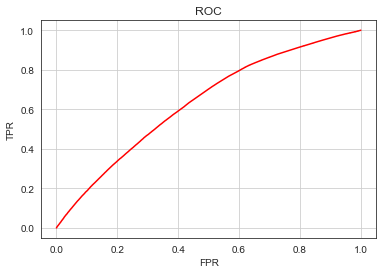

In [57]:
test_probas = pipeline.predict_proba(X_test)[:,1]

fpr, tpr, tresholds = roc_curve(y_test, test_probas)
plt.plot(fpr, tpr, color='red')
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

print('ROC-AUC-score: ', roc_auc_score(y_test, test_probas))

In [58]:
def _compute_accuracy_for_thresholds(data: pd.core.frame.DataFrame):
    """
    Compute Classifier's Accuracy for various thresholds
    """
    
    thresholds = np.linspace(0, 1, 100)
    
    accuracies = []
    
    for threshold in thresholds:
        preds = data['preds'].map(lambda x: 1 if x > threshold else 0)
        accuracy_ = accuracy_score(data['labels'].values, preds)
        accuracies.append(accuracy_)
    
    return accuracies, thresholds

In [59]:
X_test['preds'] = test_probas
X_test['labels'] = y_test

In [60]:
accuracies, thresholds = _compute_accuracy_for_thresholds(X_test)

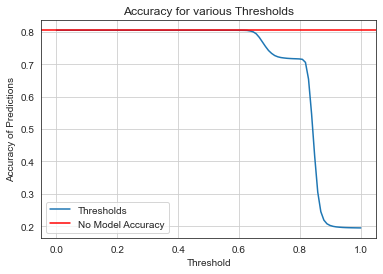

In [61]:
plt.plot(thresholds.reshape(-1, 1), accuracies, label='Thresholds')
plt.axhline(
    (X_test['labels'].sum()) / len(X_test), color='red', label='No Model Accuracy')
plt.grid()
plt.title('Accuracy for various Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy of Predictions')
plt.legend()
plt.show()

In [62]:
accuracy_score(X_test['labels'].values, list(map(lambda x: 1 if x > 0.7 else 0, X_test['preds'])))

0.7393148089674771

**Save Pipeline**

In [63]:
with open('app/model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [64]:
model = pickle.load(
    open('app/model.pkl', 'rb')
)